In [1]:
import pandas as pd
import numpy as np
import re
games = pd.read_csv('games_cleaned.csv')

In [2]:
games

,Title,Release Date,Team,Rating,Times Listed,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist,Genre_Weight,Team_Cluster,Summary_Cluster,Review_Embeddings
0,Elden Ring,2022-02-25,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900,Adventure RPG,"Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800,218.852570,8,4,[[-3.41334455e-02 -4.38266108e-03 1.30809518e...
1,Hades,2019-12-10,['Supergiant Games'],4.3,2900,Adventure Brawler Indie RPG,A rogue-lite hack and slash dungeon crawler in...,[convinced this is a roguelike for people who ...,21000,3200,6300,3600,26.383694,8,0,[[-2.78440397e-02 9.41349193e-03 6.61249757e...
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4300,Adventure RPG,The Legend of Zelda: Breath of the Wild is the...,[This game is the game (that is not CS:GO) tha...,30000,2500,5000,2600,218.852570,0,16,[[ 0.01696528 0.00396071 -0.01538952 -0.00813...
3,Undertale,2015-09-15,"['tobyfox', '8-4']",4.2,3500,Adventure Indie RPG Turn Based Strategy,"A small child falls into the Underground, wher...",[soundtrack is tied for #1 with nier automata....,28000,679,4900,1800,82.538730,6,5,[[-1.72836576e-02 -2.89896205e-02 -2.97180321e...
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,3000,Adventure Indie Platform,A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible with ...",21000,2400,8300,2300,80.642260,3,0,[[-5.08508086e-02 -1.92051195e-03 4.75870864e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,Back to the Future: The Game,2010-12-22,['Telltale Games'],3.2,94,Adventure Point-and-Click,Back to the Future: The Game is one of Telltal...,[Very enjoyable game. The story adds onto the ...,763,5,223,67,17.368029,8,10,[[ 1.86578103e-03 -3.67635973e-02 -2.50637764e...
1081,Team Sonic Racing,2019-05-21,"['Sumo Digital', 'Sega']",2.9,264,Arcade Racing,Team Sonic Racing combines the best elements o...,"[jogo morto mas bom not my cup of tea ""Compare...",1500,49,413,107,38.009930,6,14,[[-0.07032053 0.05564697 0.0136536 -0.01316...
1082,Dragon's Dogma,2012-05-22,['Capcom'],3.7,210,Brawler RPG,"Set in a huge open world, Dragon’s Dogma: Dark...",[Underrated. A grandes rasgos es como un MMO p...,1100,45,487,206,26.842472,6,11,[[-4.33658175e-02 -1.11472672e-02 -4.25991192e...
1083,Baldur's Gate 3,2020-10-06,['Larian Studios'],4.1,165,Adventure RPG Strategy Tactical Turn Based Str...,"An ancient evil has returned to Baldur's Gate,...",[Bu türe bu oyunla girmeye çalışmak hataydı sa...,269,79,388,602,45.836210,6,10,[[ 8.49182624e-03 -2.68020015e-02 1.04696816e...


Need to

* standarize numeric features with StdScalar()


In [3]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist', 'Rating']
scaler = StandardScaler()
games[numeric_features] = scaler.fit_transform(games[numeric_features])

Time to create the feature vectors for each item.

In [5]:
def parse_embedding_string(embedding_string):
    numbers = re.findall(r'-?\d+\.?\d*e?[-+]?\d*', embedding_string)
    return np.array([float(num) for num in numbers])

games['Review_Embeddings'] = games['Review_Embeddings'].apply(parse_embedding_string)

In [6]:
one_dim_features = ['Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist', 'Genre_Weight', 'Team_Cluster', 'Summary_Cluster']

def create_feature_vector(row):
    one_dim_vector = row[one_dim_features].values

    embeddings = row['Review_Embeddings']

    return np.array(np.concatenate([one_dim_vector, embeddings]), dtype=np.float64)

games['Feature_Vector'] = games.apply(create_feature_vector, axis=1)

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_games(game_index, feature_vectors, n_recommendations=5):

    similarities = cosine_similarity([feature_vectors[game_index]], feature_vectors)[0]

    similar_indices = np.argsort(similarities)[::-1][1:n_recommendations+1]

    similar_games = [(idx, similarities[idx]) for idx in similar_indices]

    return similar_games

Return the 3 most similiar scoring games to the chosen input as a baseline.

In [52]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_n_above_threshold(target_game, all_games, games_df, target_index, n=5, threshold=0.8):
    similarities = cosine_similarity([target_game], all_games)[0]

    similarities[target_index] = -1

    above_threshold = similarities > threshold
    top_indices = np.argsort(similarities[above_threshold])[-n:][::-1]
    selected_indices = np.where(above_threshold)[0][top_indices]
    selected_scores = similarities[above_threshold][top_indices]

    print(f"Top {n} similar games (threshold: {threshold}):")
    for idx, score in zip(selected_indices, selected_scores):
        game = games_df.iloc[idx]
        print(f"Title: {game['Title']}")
        print(f"Genres: {game['Genres']}")
        print(f"Team: {game['Team']}")
        print(f"Summary: {game['Summary']}")
        print(f"Similarity Score: {score:.4f}")
        print()

    return selected_indices, selected_scores

target_game_index = 0
all_game_vectors = np.stack(games['Feature_Vector'])

similar_indices, similar_scores = get_top_n_above_threshold(
    games['Feature_Vector'][target_game_index],
    all_game_vectors,
    games,
    target_game_index,
    n=3,
    threshold=0.9
)

target_game = games.iloc[target_game_index]
print(f"\nTarget game:")
print(f"Title: {target_game['Title']}")
print(f"Genres: {target_game['Genres']}")
print(f"Team: {target_game['Team']}")
print(f"Summary: {target_game['Summary']}")

Top 3 similar games (threshold: 0.9):
Title: Metroid Dread
Genres: Adventure Platform
Team: ['Nintendo', 'MercurySteam']
Summary: Join intergalactic bounty hunter Samus Aran in her first new 2D Metroid story in 19 years. Samus’ story continues after the events of the Metroid Fusion game when she descends upon planet ZDR to investigate a mysterious transmission sent to the Galactic Federation. The remote planet has become overrun by vicious alien lifeforms and chilling mechanical menaces. Samus is more agile and capable than ever, but can she overcome the inhuman threat stalking the depths of ZDR?
Similarity Score: 0.9990

Title: Kirby and the Forgotten Land
Genres: Adventure Platform
Team: ['HAL Laboratory', 'Nintendo']
Summary: Join Kirby in an unforgettable journey through a mysterious world in a delightful 3D platforming adventure. Take control of the powerful pink puffball, Kirby, and move around freely in 3D stages as you discover a mysterious world with abandoned structures from 

Not the best selection of games, and the similarity scores are extremely high, suggesting an oversimplification of the selection process. Elden Ring is a much more mature game in comparison to Mario and Kirby.

Let's implement a multilayer perceptron (MLP) to find feature weights when forming the vectors.

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.initializers import VarianceScaling
import numpy as np

X = games[['Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist',
           'Genre_Weight', 'Team_Cluster', 'Summary_Cluster']].values
review_embeddings = np.stack(games['Review_Embeddings'].values)
X = np.concatenate([X, review_embeddings], axis=1)

y = np.stack(games['Feature_Vector'].values)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_normalized = (X - X_mean) / X_std

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

def create_model(input_dim, output_dim):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,),
                     kernel_initializer=VarianceScaling(),
                     bias_initializer='zeros'),
        layers.Dense(512, activation='relu',
                     kernel_initializer=VarianceScaling(),
                     bias_initializer='zeros'),
        layers.Dense(1024, activation='relu',
                     kernel_initializer=VarianceScaling(),
                     bias_initializer='zeros'),
        layers.Dense(output_dim, activation=None,
                     kernel_initializer=VarianceScaling(),
                     bias_initializer='zeros')
    ])
    return model

model = create_model(X_train.shape[1], y_train.shape[1])
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

predictions = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 19.4112 - val_loss: 11.0957
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.6215 - val_loss: 8.4719
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.0976 - val_loss: 6.9515
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3774 - val_loss: 5.8845
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0867 - val_loss: 4.8309
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5683 - val_loss: 4.9592
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4363 - val_loss: 4.2433
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3530 - val_loss: 4.8584
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3097 - val_loss: 4.5081
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2930 - val_loss: 4.4001
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2454 - val_loss: 4.0867
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/st

In [30]:
model.save('game_recommendation_model.keras')

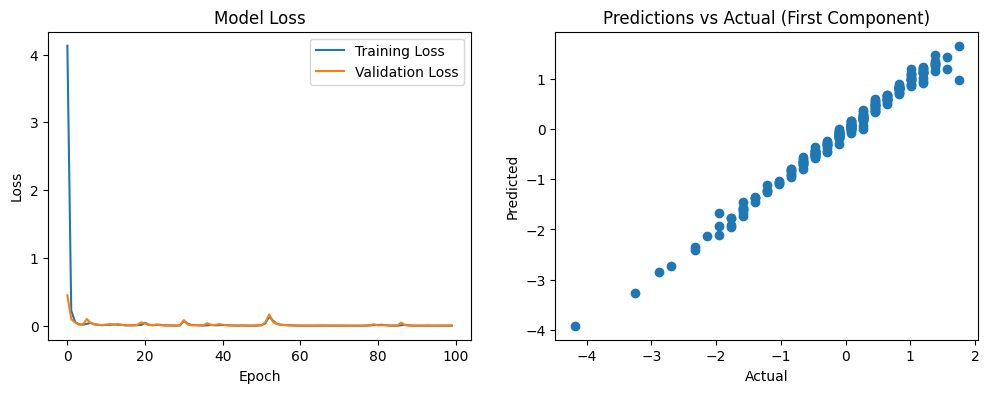

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 0], predictions[:, 0])
plt.title('Predictions vs Actual (First Component)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Training loss looks good, but validation loss plateaus. The predictions look good as well. To address the plateau, I incorporate the following:

* L2 Regularization
* Batch Normalization
* Dropout Layers
* ReduceLROnPlateau
* Early Stoppage
* Increased epochs to 200

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 36.5155 - val_loss: 38.8433 - learning_rate: 0.0010
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 29.0291 - val_loss: 35.3768 - learning_rate: 0.0010
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 25.1592 - val_loss: 31.6289 - learning_rate: 0.0010
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 21.3059 - val_loss: 28.6304 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 17.9757 - val_loss: 25.6321 - learning_rate: 0.0010
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 16.9107 - val_loss: 23.1155 - learning_rate: 0.0010
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 14.3027 - val_loss: 21.9086 - learning_rate: 0.0010
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 13.3987 - val_loss: 19.3385 - learning_rate: 0.0010
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 11.4893 - val_loss: 17.7014 - learning_rate: 0.0010
Epoc

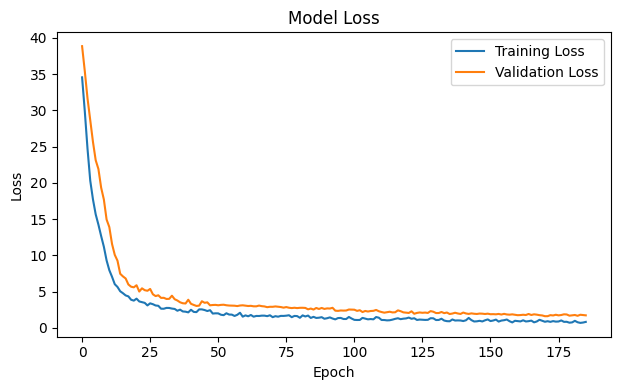

In [61]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

X = games[['Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist',
           'Genre_Weight', 'Team_Cluster', 'Summary_Cluster']].values
review_embeddings = np.stack(games['Review_Embeddings'].values)
X = np.concatenate([X, review_embeddings], axis=1)

y = np.stack(games['Feature_Vector'].values)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_normalized = (X - X_mean) / X_std

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

def create_model(input_dim, output_dim):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,),
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(output_dim, activation=None)
    ])
    return model

model = create_model(X_train.shape[1], y_train.shape[1])
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stop],
                    verbose=1)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

predictions = model.predict(X_test)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('model2.keras')

In [66]:
from tensorflow import keras
loaded_model = keras.models.load_model('model2.keras')

In [69]:
def get_first_layer_weights(model):
    first_layer_weights = loaded_model.layers[0].get_weights()[0]
    feature_names = ['Rating', 'Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist',
                     'Genre_Weight', 'Team_Cluster', 'Summary_Cluster']

    avg_weights = np.mean(np.abs(first_layer_weights), axis=1)

    weight_dict = dict(zip(feature_names, avg_weights))

    sorted_weights = sorted(weight_dict.items(), key=lambda x: x[1], reverse=True)

    return sorted_weights

weights = get_first_layer_weights(model)
for feature, weight in weights[:20]:
    print(f"{feature}: {weight}")

Genre_Weight: 0.12140718102455139
Summary_Cluster: 0.03049813210964203
Team_Cluster: 0.021587425842881203
Backlogs: 0.013460557907819748
Wishlist: 0.012612138874828815
Times Listed: 0.012331909500062466
Playing: 0.011805211193859577
Rating: 0.011224673129618168
Plays: 0.010858454741537571


In [71]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

weights = {
    'Genre_Weight': 0.12140718102455139,
    'Summary_Cluster': 0.03049813210964203,
    'Team_Cluster': 0.021587425842881203,
    'Backlogs': 0.013460557907819748,
    'Wishlist': 0.012612138874828815,
    'Times Listed': 0.012331909500062466,
    'Playing': 0.011805211193859577,
    'Rating': 0.011224673129618168,
    'Plays': 0.010858454741537571
}

def weighted_cosine_similarity(X, Y, weights):
    X_weighted = X * weights
    Y_weighted = Y * weights
    return cosine_similarity(X_weighted, Y_weighted)

def get_top_n_above_threshold(target_game, all_games, games_df, target_index, feature_weights, n=5, threshold=0.8):
    all_games = np.array(all_games.tolist())
    target_game = np.array(target_game)

    scaler = StandardScaler()
    all_games_scaled = scaler.fit_transform(all_games)
    target_game_scaled = scaler.transform(target_game.reshape(1, -1))

    similarities = weighted_cosine_similarity(target_game_scaled, all_games_scaled, feature_weights)[0]

    similarities[target_index] = -1

    above_threshold = similarities > threshold
    top_indices = np.argsort(similarities[above_threshold])[-n:][::-1]
    selected_indices = np.where(above_threshold)[0][top_indices]
    selected_scores = similarities[above_threshold][top_indices]

    print(f"Top {len(selected_indices)} similar games (threshold: {threshold}):")
    for idx, score in zip(selected_indices, selected_scores):
        game = games_df.iloc[idx]
        print(f"Title: {game['Title']}")
        print(f"Genres: {game['Genres']}")
        print(f"Team: {game['Team']}")
        print(f"Summary: {game['Summary']}")
        print(f"Similarity Score: {score:.4f}")
        print()

    return selected_indices, selected_scores

feature_weights = np.ones(games['Feature_Vector'].iloc[0].shape)
for i, feature in enumerate(games.columns):
    if feature in weights:
        feature_weights[i] = weights[feature]

target_game_index = 0
all_game_vectors = np.stack(games['Feature_Vector'])

print(f"\nTarget game:")
target_game = games.iloc[target_game_index]
print(f"Title: {target_game['Title']}")
print(f"Genres: {target_game['Genres']}")
print(f"Team: {target_game['Team']}")
print(f"Summary: {target_game['Summary']}")
print("\nSimilar games:")

similar_indices, similar_scores = get_top_n_above_threshold(
    games['Feature_Vector'][target_game_index],
    all_game_vectors,
    games,
    target_game_index,
    feature_weights,
    n=3,
    threshold=0
)


Target game:
Title: Elden Ring
Genres: Adventure RPG
Team: ['Bandai Namco Entertainment', 'FromSoftware']
Summary: Elden Ring is a fantasy, action and open world game with RPG elements such as stats, weapons and spells. Rise, Tarnished, and be guided by grace to brandish the power of the Elden Ring and become an Elden Lord in the Lands Between.

Similar games:
Top 3 similar games (threshold: 0):
Title: The Witcher 3: Wild Hunt
Genres: Adventure RPG
Team: ['WB Games', 'CD Projekt RED']
Summary: RPG and sequel to The Witcher 2 (2011), The Witcher 3 follows witcher Geralt of Rivia as he seeks out his former lover and his young subject while intermingling with the political workings of the wartorn Northern Kingdoms. Geralt has to fight monsters and deal with people of all sorts in order to solve complex problems and settle contentious disputes, each ranging from the personal to the world-changing.
Similarity Score: 0.3576

Title: Bloodborne
Genres: Adventure RPG
Team: ['FromSoftware', 'So

This is a much better selection, with all three recs being in a dark, medieval fantasy setting.